In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

In [2]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'examples/deconv_deploy.prototxt',
                '/home/lew/myCourse/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB


In [3]:
# set net to batch size of 50
net.blobs['data'].reshape(1,3,227,227)
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('pool1_mask', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('pool2_mask', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('pool5_mask', (10, 256, 6, 6)),
 ('pool5_pool5_0_split_0', (10, 256, 6, 6)),
 ('pool5_pool5_0_split_1', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000)),
 ('unpool5', (10, 256, 13, 13)),
 ('relu5t', (10, 256, 13, 13)),
 ('conv5t', (10, 384, 13, 13)),
 ('relu4t', (10, 384, 13, 13)),
 ('conv4t', (10, 384, 13, 13)),
 ('relu3t', (10, 384, 13, 13)),
 ('conv3t', (10, 256, 13, 13)),
 ('unpool2', (10, 256, 27, 27)),
 ('relu2t', (10, 256, 27, 27)),
 ('conv2t', (10, 96, 27, 27)),
 ('unpool1', (10, 96, 55, 55)),
 ('relu1t', (10, 96, 55, 55))

In [18]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/381.jpg'))

In [19]:
net.params["conv1t"][0].data[...] = net.params["conv1"][0].data.transpose(0,1,3,2)
net.params["conv2t"][0].data[...] = net.params["conv2"][0].data.transpose(0,1,3,2)
net.params["conv3t"][0].data[...] = net.params["conv3"][0].data.transpose(0,1,3,2)
net.params["conv4t"][0].data[...] = net.params["conv4"][0].data.transpose(0,1,3,2)
net.params["conv5t"][0].data[...] = net.params["conv5"][0].data.transpose(0,1,3,2)
print net.params['conv1t'][0].data.shape, net.params['conv1'][0].data.shape

(96, 3, 11, 11) (96, 3, 11, 11)


In [30]:
#############################
#           Test for net.forward from to         #
#############################

#  Actually when doing forward, Caffe automatically 
#  create split layer for any input blobs used by other 
#  layers as bottom blobs more than once.

#o1=net.forward(end='conv2t')
#o2=net.forward(start='unpool2', end='unpool5')
#print net.blobs['unpool2'].data[0].max()

o1=net.forward(end='prob')
o2=net.forward(start='unpool5')
print net.blobs['unpool5'].data[0].max()

248.062


In [9]:

## reconstruct from conv3
# First find the top 9 activations of conv3, then zero out other activations
# and then use one of several of the 9 activations to reconstruct an image
oo = net.forward(end = "conv3t")
print net.blobs['conv3'].data[0].shape
d = net.blobs['conv3'].data[0].copy()
d = d.reshape(64896)
indices = np.argsort(d)
ind = indices[-9:]
print indices[-9:], net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13]

(384, 13, 13)
[ 3045  3110 53279 29294  5082 55178 63252 29295 63251] [ 216.05059814  221.50346375  223.22021484  224.60527039  236.5695343
  245.23312378  249.82415771  252.1696167   254.04649353]


In [10]:
keep = net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13]
net.blobs['conv3'].data[...] = 0
i = 7
net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13] = keep
#net.blobs['conv3'].data[0][ind[i]//169, (ind[i]%169)//13, ind[i]%169%13] = keep[i]
print net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13]
ii = net.blobs['conv3'].data[0] != 0

[ 216.05059814  221.50346375  223.22021484  224.60527039  236.5695343
  245.23312378  249.82415771  252.1696167   254.04649353]


In [22]:
## reconstruct from pool5
# First find the top 9 activations of pool5, then zero out other activations
# and then use one of several of the 9 activations to reconstruct an image
oo = net.forward(end = "unpool5")
print net.blobs['pool5'].data[0].shape
d = net.blobs['pool5'].data[0].copy()
d = d.reshape(9216)
indices = np.argsort(d)
ind = indices[-50:]
print indices[-9:], net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6], net.blobs['pool5_mask'].data[0][ind//36, (ind%36)//6, ind%36%6]

(256, 6, 6)
[7487 3207 3208 5727 5466 7779 7785 7786 7780] [  51.51252365   51.51252365   51.53387451   51.53387451   52.7091217
   53.14208603   53.29489136   53.29489136   53.57675552   53.57675552
   53.57675552   53.57675552   54.33551407   55.63537216   56.09167862
   56.09167862   58.13492966   59.15321732   60.30814743   60.37004852
   60.37004852   60.71749496   62.76303482   63.65216827   63.65216827
   63.87901688   63.95518112   64.82765961   65.59806061   65.59806061
   65.65344238   65.65344238   66.49399567   66.53031921   67.09462738
   67.20187378   67.27207947   69.01023102   75.02962494   75.5002594
   75.5002594    81.01307678   82.48947906   82.48947906   85.58492279
   90.76203918   96.34114075   96.34114075  119.9741745   119.9741745 ] [  75.   75.   64.   64.    9.    8.   29.   29.   80.   80.   80.   80.
  146.  121.  145.  145.   17.   17.   16.   43.   43.  120.   19.   21.
   21.   32.   18.   20.  145.  145.    8.    8.   18.  156.  131.   21.
  154.  141. 

In [23]:
keep = net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6]
net.blobs['pool5'].data[...] = 0
i = 8
net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6] = keep
# net.blobs['pool5'].data[0][ind[i]//36, (ind[i]%36)//6, ind[i]%36%6] = keep[i]
print net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6] 
ii = net.blobs['pool5'].data[0] != 0

[  51.51252365   51.51252365   51.53387451   51.53387451   52.7091217
   53.14208603   53.29489136   53.29489136   53.57675552   53.57675552
   53.57675552   53.57675552   54.33551407   55.63537216   56.09167862
   56.09167862   58.13492966   59.15321732   60.30814743   60.37004852
   60.37004852   60.71749496   62.76303482   63.65216827   63.65216827
   63.87901688   63.95518112   64.82765961   65.59806061   65.59806061
   65.65344238   65.65344238   66.49399567   66.53031921   67.09462738
   67.20187378   67.27207947   69.01023102   75.02962494   75.5002594
   75.5002594    81.01307678   82.48947906   82.48947906   85.58492279
   90.76203918   96.34114075   96.34114075  119.9741745   119.9741745 ]


In [12]:
#filters = net.params["conv5"][0].data.copy()
#net.params["conv5"][0].data[...] = 0
#net.params["conv5"][0].data[0] = filters[0]

out = net.forward()
#ii = net.blobs['pool5'].data[0] != 0
#da = net.blobs['conv3t'].data[0][net.blobs['conv3t'].data[0]!=0] 
#print da

In [24]:
out = net.forward(start='unpool5')

In [29]:
print net.blobs['conv5t'].data[0].max()
o = net.blobs['conv1t'].data[0].copy()
print o.shape
o -= o.min()
o /= o.max()
o *= 255
o = np.rollaxis(o, 0, 3)

print o.shape


55.3698
(3, 227, 227)
(227, 227, 3)


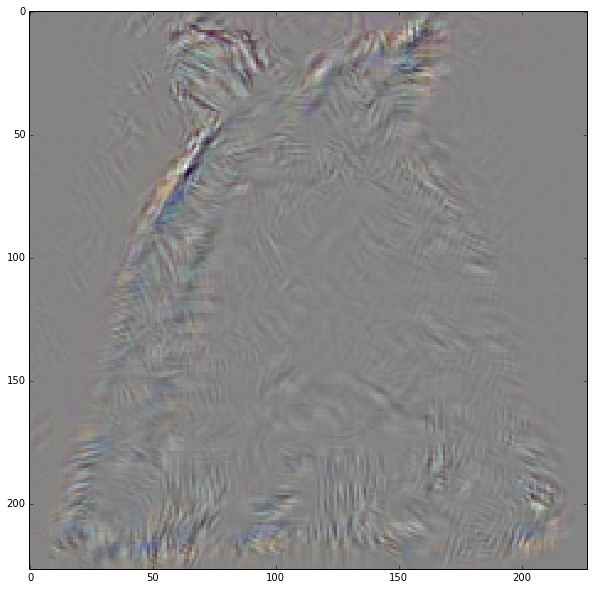

In [30]:
plt.imshow(o.astype(np.uint8))
#plt.savefig(caffe_root + 'examples/images/dog1_pool5_one.jpg')

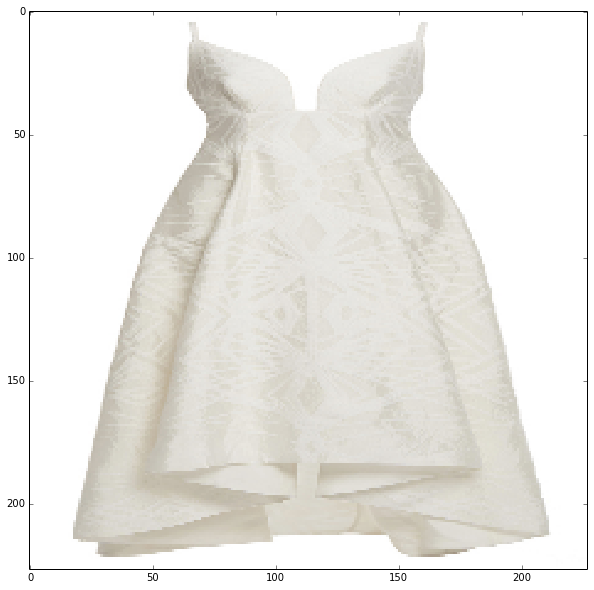

In [27]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
#plt.savefig(caffe_root + 'examples/images/dog1_wrapped.jpg')

In [28]:
# Let's try to change deconvnet into guided back-propagation!

# First, we stop at the relu5t 
net.forward(end = "relu5t")
net.blobs['unpool5'].data[0][:] = net.blobs['unpool5'].data[0] * (net.blobs['conv5'].data[0] > 0)
print net.blobs['unpool5'].data[0].max()
# Then relu4t
net.forward(start = 'relu5t', end = 'relu4t')
print net.blobs['conv5t'].data[0].max()
net.blobs['conv5t'].data[0][:] = net.blobs['conv5t'].data[0] * (net.blobs['conv4'].data[0] > 0)
print net.blobs['conv5t'].data[0].max()
# Then relu3t
net.forward(start = 'relu4t', end = 'relu3t')
net.blobs['conv4t'].data[0][:] = net.blobs['conv4t'].data[0] * (net.blobs['conv3'].data[0] > 0)
# Then relu4t
net.forward(start = 'relu3t', end = 'relu2t')
net.blobs['unpool2'].data[0][:] = net.blobs['unpool2'].data[0] * (net.blobs['conv2'].data[0] > 0)
# Then relu4t
net.forward(start = 'relu2t', end = 'relu1t')
net.blobs['unpool1'].data[0][:] = net.blobs['unpool1'].data[0] * (net.blobs['conv1'].data[0] > 0)

#######
out = net.forward(start = 'relu1t')

119.974
55.3698
55.3698
